In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from linearmodels.panel import compare
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS, RandomEffects
from scipy.stats import chi2
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

In [2]:
# Load data
file_path = '../data/CA2_filled.csv'
data = pd.read_csv(file_path)

# Data preprocessing: dependent and independent variables
# Dependent variable: log(GDP)
# Independent variables: edu_m, edu_f, gra_m, gra_f, gee, er_m, er_f, law, cpi

# Convert variables to appropriate data types (ensure correctness)
data['Country'] = data['Country'].astype('category')
data['Year'] = data['Year'].astype('int')

# Apply log transformation to gdp
data['log_gdp'] = np.log(data['gdp'])

In [3]:
data['gpi'] = data['edu_f'] / data['edu_m']

# Multicollinearity check

In [4]:
# Multicollinearity check using Variance Inflation Factor (VIF)
print("\nVariance Inflation Factor (VIF) before removing variables:")
X = data[['log_gdp', 'gpi', 'gee', 'er_m', 'er_f', 'law', 'cpi']].copy()
X.loc[:, 'Intercept'] = 1  # Add intercept for VIF calculation
vif_data_before = pd.DataFrame()
vif_data_before['Variable'] = X.columns
vif_data_before['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data_before)


Variance Inflation Factor (VIF) before removing variables:
    Variable          VIF
0    log_gdp     4.394076
1        gpi     2.323561
2        gee     2.752525
3       er_m     5.068563
4       er_f     2.039909
5        law     2.791146
6        cpi     1.563645
7  Intercept  1108.911946


# hausman test ---choose FE model

In [5]:
# Hausman test for fixed vs. random effects
# Using linearmodels library for panel data regression
from linearmodels.panel import compare

# Fixed effects model
fixed_effects = PanelOLS.from_formula('edu ~ log_gdp + gpi + gee + er_m + er_f + law + cpi + EntityEffects', data=data.set_index(['Country', 'Year'])).fit()

# Random effects model
random_effects = RandomEffects.from_formula('edu ~ log_gdp + gpi + gee + er_m + er_f + law + cpi', data=data.set_index(['Country', 'Year'])).fit()

# Standard Hausman test
print("\nHausman Test:")
fe_params = fixed_effects.params
re_params = random_effects.params
common_params = fe_params.index.intersection(re_params.index)

b_diff = fe_params[common_params] - re_params[common_params]
V_fe = fixed_effects.cov.loc[common_params, common_params]
V_re = random_effects.cov.loc[common_params, common_params]
V_diff = V_fe - V_re

hausman_stat = b_diff.T @ np.linalg.inv(V_diff) @ b_diff
p_value = 1 - chi2.cdf(hausman_stat, len(common_params))

print(f"Hausman Statistic: {hausman_stat}")
print(f"P-value: {p_value}")



Hausman Test:
Hausman Statistic: 82.97849316166014
P-value: 3.4416913763379853e-15


d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o

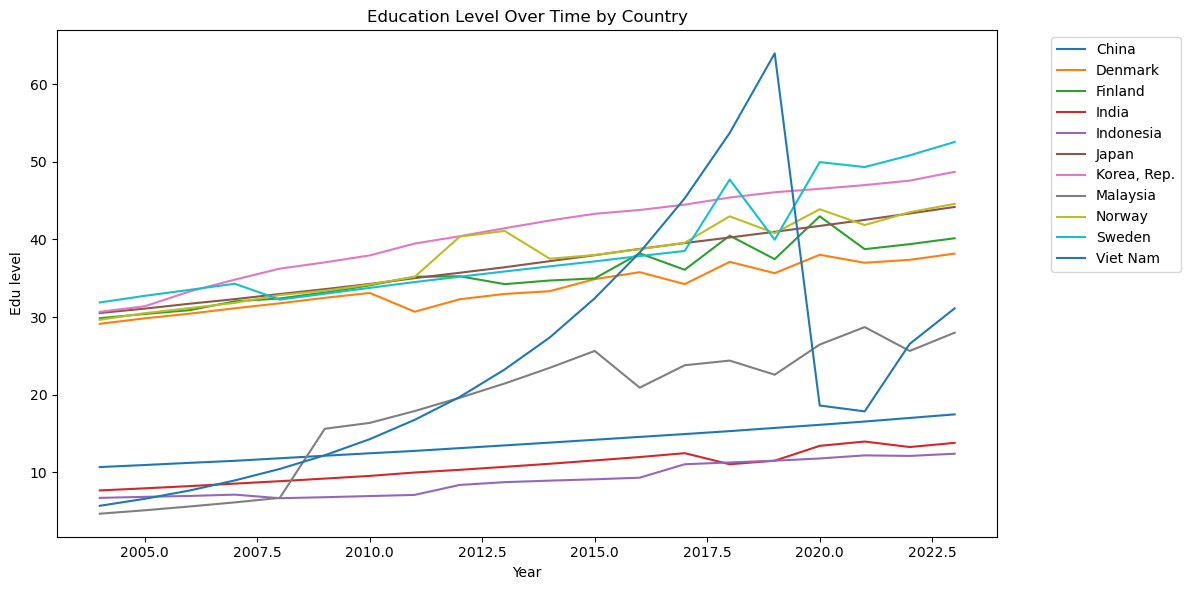

In [6]:
# Plot Education Level over time for each country using seaborn
plt.figure(figsize=(12, 6))
for country in data['Country'].unique():
    country_data = data[data['Country'] == country]
    plt.plot(country_data['Year'], country_data['edu'], label=country)

plt.xlabel('Year')
plt.ylabel('Edu level')
plt.title('Education Level Over Time by Country')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# without interactions

In [7]:
# Fixed effects regression
fe_model = PanelOLS.from_formula('edu ~ log_gdp + gpi +gee + er_m + er_f + law + cpi + EntityEffects', 
                                 data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')
# Output the regression result
print("\nFixed Effects Regression Results:")
print(fe_model.summary)

# Fixed effects regression for male data only with robust standard errors
fe_model_male = PanelOLS.from_formula('edu ~ log_gdp + gpi + gee + er_m + law + cpi + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')
# Output the regression result for male data
print("\nFixed Effects Regression Results (Male) with Robust Standard Errors:")
print(fe_model_male.summary)

# Fixed effects regression for female data only with robust standard errors
fe_model_female = PanelOLS.from_formula('edu ~ log_gdp + gpi + gee + er_f + law + cpi + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')
# Output the regression result for female data
print("\nFixed Effects Regression Results (Female) with Robust Standard Errors:")
print(fe_model_female.summary)


Fixed Effects Regression Results:
                          PanelOLS Estimation Summary                           
Dep. Variable:                    edu   R-squared:                        0.5759
Estimator:                   PanelOLS   R-squared (Between):             -15.277
No. Observations:                 220   R-squared (Within):               0.5759
Date:                Fri, Oct 25 2024   R-squared (Overall):             -14.552
Time:                        00:53:11   Log-likelihood                   -629.31
Cov. Estimator:                Robust                                           
                                        F-statistic:                      39.182
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(7,202)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o

# with interactions

In [8]:
# Create interaction terms
data['law_er_m'] = data['law'] * data['er_m']
data['law_er_f'] = data['law'] * data['er_f']

In [9]:
# Fixed effects regression with interaction terms
fe_model1 = PanelOLS.from_formula('edu ~ log_gdp + gpi + gee + er_m + er_f + law + cpi + law_er_m + law_er_f + EntityEffects',
                                 data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')
# Output the regression result
print("\nFixed Effects Regression Results with Interaction Terms:")
print(fe_model1.summary)

# Fixed effects regression for male data only with interaction term and robust standard errors
fe_model_male1 = PanelOLS.from_formula('edu ~ log_gdp + gpi + gee + er_m + law + cpi + law_er_m + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')
# Output the regression result for male data
print("\nFixed Effects Regression Results (Male) with Interaction Term and Robust Standard Errors:")
print(fe_model_male1.summary)

# Fixed effects regression for female data only with interaction term and robust standard errors
fe_model_female1 = PanelOLS.from_formula('edu ~ log_gdp + gpi + gee + er_f + law + cpi + law_er_f + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')
# Output the regression result for female data
print("\nFixed Effects Regression Results (Female) with Interaction Term and Robust Standard Errors:")
print(fe_model_female1.summary)

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o


Fixed Effects Regression Results with Interaction Terms:
                          PanelOLS Estimation Summary                           
Dep. Variable:                    edu   R-squared:                        0.5968
Estimator:                   PanelOLS   R-squared (Between):             -9.4545
No. Observations:                 220   R-squared (Within):               0.5968
Date:                Fri, Oct 25 2024   R-squared (Overall):             -8.9950
Time:                        00:53:12   Log-likelihood                   -623.73
Cov. Estimator:                Robust                                           
                                        F-statistic:                      32.899
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(9,200)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o

# Robustness check

In [11]:
# Fixed effects regression with interaction terms
fe_model = PanelOLS.from_formula('edu ~ log_gdp + gpi + gee + er_m + er_f + law + cpi + law_er_m + law_er_f + EntityEffects', 
                                 data=data.set_index(['Country', 'Year'])).fit(cov_type='kernel')
# Output the regression result
print("\nFixed Effects Regression Results with Interaction Terms and kernel Standard Errors:")
print(fe_model.summary)

# Fixed effects regression for male data only with interaction term and kernel standard errors
fe_model_male = PanelOLS.from_formula('edu ~ log_gdp + gpi + gee + er_m + law + cpi + law_er_m + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='kernel')
# Output the regression result for male data
print("\nFixed Effects Regression Results (Male) with Interaction Term and kernel Standard Errors:")
print(fe_model_male.summary)

# Fixed effects regression for female data only with interaction term and kernel standard errors
fe_model_female = PanelOLS.from_formula('edu ~ log_gdp + gpi + gee + er_f + law + cpi + law_er_f + EntityEffects', data=data.set_index(['Country', 'Year'])).fit(cov_type='kernel')
# Output the regression result for female data
print("\nFixed Effects Regression Results (Female) with Interaction Term and kernel Standard Errors:")
print(fe_model_female.summary)


Fixed Effects Regression Results with Interaction Terms and kernel Standard Errors:
                          PanelOLS Estimation Summary                           
Dep. Variable:                    edu   R-squared:                        0.5968
Estimator:                   PanelOLS   R-squared (Between):             -9.4545
No. Observations:                 220   R-squared (Within):               0.5968
Date:                Fri, Oct 25 2024   R-squared (Overall):             -8.9950
Time:                        00:54:19   Log-likelihood                   -623.73
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      32.899
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(9,200)
Min Obs:                       20.000                                           
Max Obs:                

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o